# Meeting 06

## Unit 16 Nearest Neighbors

In [1]:
import matplotlib
#matplotlib.use('Agg')
path_data = 'https://raw.githubusercontent.com/taecoding/data/master/cs61/data8assets/textbook/chapters/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

In [2]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [3]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

### Nearest Neighbors ###
In this section we'll develop the *nearest neighbor* method of classification. Just focus on the ideas for now and don't worry if some of the code is mysterious. Later in the chapter we'll see how to organize our ideas into code that performs the classification.

### Chronic kidney disease

Let's work through an example.  We're going to work with a data set that was collected to help doctors diagnose chronic kidney disease (CKD).  Each row in the data set represents a single patient who was treated in the past and whose diagnosis is known.  For each patient, we have a bunch of measurements from a blood test.  We'd like to find which measurements are most useful for diagnosing CKD, and develop a way to classify future patients as "has CKD" or "doesn't have CKD" based on their blood test results.

In [4]:
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


Some of the variables are categorical (words like "abnormal"), and some quantitative. The quantitative variables all have different scales. We're going to want to make comparisons and estimate distances, often by eye, so let's select just a few of the variables and work in standard units. Then we won't have to worry about the scale of each of the different variables.

In [5]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

In [6]:
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


Let's look at two columns in particular: the hemoglobin level (in the patient's blood), and the blood glucose level (at a random time in the day; without fasting specially for the blood test). 

We'll draw a scatter plot to visualize the relation between the two variables. Blue dots are patients with CKD; gold dots are patients without CKD.  What kind of medical test results seem to indicate CKD?

In [7]:
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

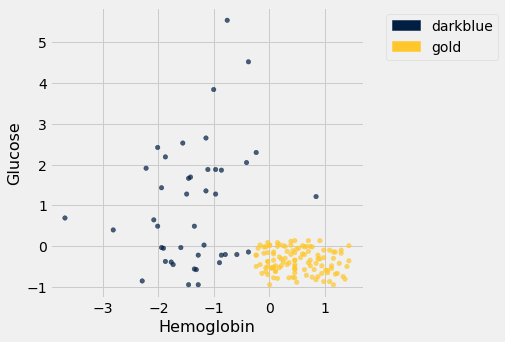

In [8]:
ckd.scatter('Hemoglobin', 'Glucose', colors='Color')

Suppose Alice is a new patient who is not in the data set.  If I tell you Alice's hemoglobin level and blood glucose level, could you predict whether she has CKD?  It sure looks like it!  You can see a very clear pattern here: points in the lower-right tend to represent people who don't have CKD, and the rest tend to be folks with CKD.  To a human, the pattern is obvious.  But how can we program a computer to automatically detect patterns such as this one?

### A Nearest Neighbor Classifier ###

There are lots of kinds of patterns one might look for, and lots of algorithms for classification.  But I'm going to tell you about one that turns out to be surprisingly effective.  It is called *nearest neighbor classification*.  Here's the idea.  If we have Alice's hemoglobin and glucose numbers, we can put her somewhere on this scatterplot; the hemoglobin is her x-coordinate, and the glucose is her y-coordinate.  Now, to predict whether she has CKD or not, we find the nearest point in the scatterplot and check whether it is blue or gold; we predict that Alice should receive the same diagnosis as that patient.

In other words, to classify Alice as CKD or not, we find the patient in the training set who is "nearest" to Alice, and then use that patient's diagnosis as our prediction for Alice.  The intuition is that if two points are near each other in the scatterplot, then the corresponding measurements are pretty similar, so we might expect them to receive the same diagnosis (more likely than not).  We don't know Alice's diagnosis, but we do know the diagnosis of all the patients in the training set, so we find the patient in the training set who is most similar to Alice, and use that patient's diagnosis to predict Alice's diagnosis.

In the graph below, the red dot represents Alice. It is joined with a black line to the point that is nearest to it – its *nearest neighbor* in the training set. The figure is drawn by a function called `show_closest`. It takes an array that represents the $x$ and $y$ coordinates of Alice's point. Vary those to see how the closest point changes! Note especially when the closest point is blue and when it is gold.

In [9]:
def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.drop('White Blood Cell Count', 'Color')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(1)
    y_closest = t.row(0).item(2)
    ckd.scatter('Hemoglobin', 'Glucose', colors='Color')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);

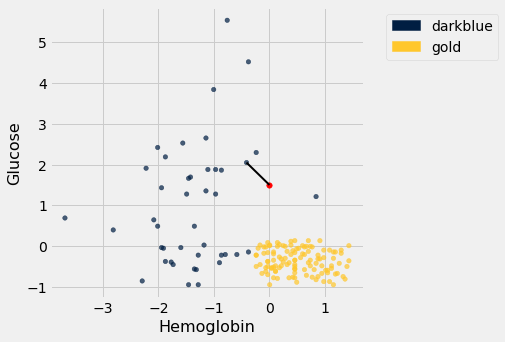

In [10]:
# In this example, Alice's Hemoglobin attribute is 0 and her Glucose is 1.5.
alice = make_array(0, 1.5)
show_closest(alice)

Thus our *nearest neighbor classifier* works like this:
- Find the point in the training set that is nearest to the new point.
- If that nearest point is a "CKD" point, classify the new point as "CKD". If the nearest point is a "not CKD" point, classify the new point as "not CKD".

The scatterplot suggests that this nearest neighbor classifier should be pretty accurate.  Points in the lower-right will tend to receive a "no CKD" diagnosis, as their nearest neighbor will be a gold point.  The rest of the points will tend to receive a "CKD" diagnosis, as their nearest neighbor will be a blue point.  So the nearest neighbor strategy seems to capture our intuition pretty well, for this example.

### Decision boundary ###

Sometimes a helpful way to visualize a classifier is to map out the kinds of attributes where the classifier would predict 'CKD', and the kinds where it would predict 'not CKD'.  We end up with some boundary between the two, where points on one side of the boundary will be classified 'CKD' and points on the other side will be classified 'not CKD'.  This boundary is called the *decision boundary*.  Each different classifier will have a different decision boundary; the decision boundary is just a way to visualize what criteria the classifier is using to classify points.

For example, suppose the coordinates of Alice's point are (0, 1.5). Notice that the nearest neighbor is blue. Now try reducing the height (the $y$-coordinate) of the point. You'll see that at around $y = 0.95$ the nearest neighbor turns from blue to gold.

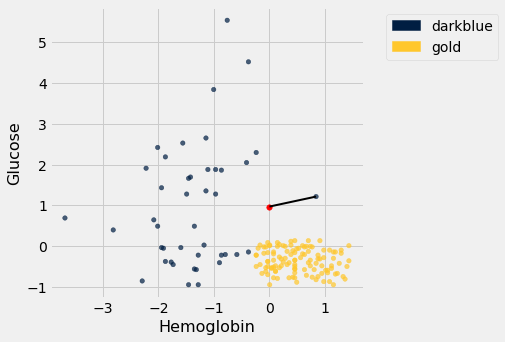

In [11]:
alice = make_array(0, 0.97)
show_closest(alice)

Here are hundreds of new unclassified points, all in red.

In [12]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

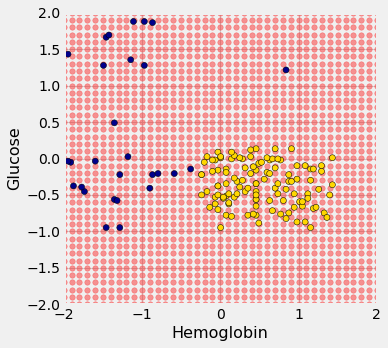

In [13]:
test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

Each of the red points has a nearest neighbor in the training set (the same blue and gold points as before). For some red points you can easily tell whether the nearest neighbor is blue or gold. For others, it's a little more tricky to make the decision by eye. Those are the points near the decision boundary.

But the computer can easily determine the nearest neighbor of each point. So let's get it to apply our nearest neighbor classifier to each of the red points: 

For each red point, it must find the closest point in the training set; it must then change the color of the red point to become the color of the nearest neighbor. 

The resulting graph shows which points will get classified as 'CKD' (all the blue ones), and which as 'not CKD' (all the gold ones).

In [14]:
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [15]:
c = classify_grid(ckd.drop('White Blood Cell Count', 'Color'), test_grid, 1)

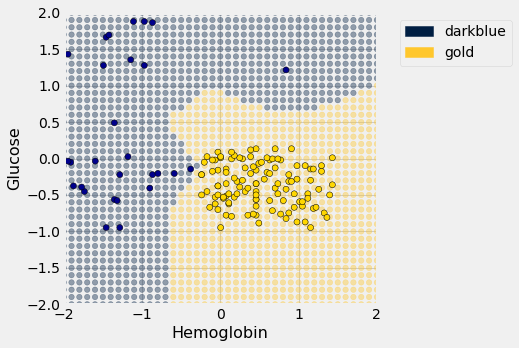

In [16]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('Hemoglobin', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2);

The decision boundary is where the classifier switches from turning the red points blue to turning them gold.

### k-Nearest Neighbors ###

However, the separation between the two classes won't always be quite so clean.  For instance, suppose that instead of hemoglobin levels we were to look at white blood cell count.  Look at what happens:

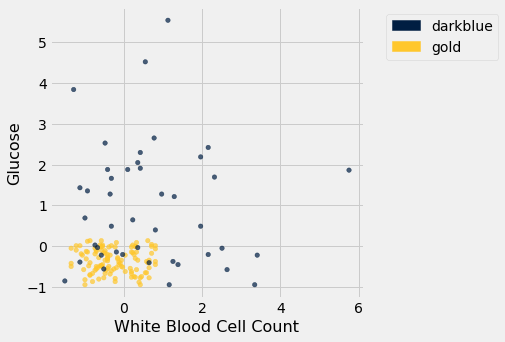

In [17]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Color')

As you can see, non-CKD individuals are all clustered in the lower-left.  Most of the patients with CKD are above or to the right of that cluster... but not all.  There are some patients with CKD who are in the lower left of the above figure (as indicated by the handful of blue dots scattered among the gold cluster).  What this means is that you can't tell for certain whether someone has CKD from just these two blood test measurements.

If we are given Alice's glucose level and white blood cell count, can we predict whether she has CKD?  Yes, we can make a prediction, but we shouldn't expect it to be 100% accurate.  Intuitively, it seems like there's a natural strategy for predicting: plot where Alice lands in the scatter plot; if she is in the lower-left, predict that she doesn't have CKD, otherwise predict she has CKD.  

This isn't perfect -- our predictions will sometimes be wrong.  (Take a minute and think it through: for which patients will it make a mistake?)  As the scatterplot above indicates, sometimes people with CKD have glucose and white blood cell levels that look identical to those of someone without CKD, so any classifier is inevitably going to make the wrong prediction for them.

Can we automate this on a computer?  Well, the nearest neighbor classifier would be a reasonable choice here too.  Take a minute and think it through: how will its predictions compare to those from the intuitive strategy above?  When will they differ?

Its predictions will be pretty similar to our intuitive strategy, but occasionally it will make a different prediction.  In particular, if Alice's blood test results happen to put her right near one of the blue dots in the lower-left, the intuitive strategy would predict 'not CKD', whereas the nearest neighbor classifier will predict 'CKD'.

There is a simple generalization of the nearest neighbor classifier that fixes this anomaly.  It is called the *k-nearest neighbor classifier*.  To predict Alice's diagnosis, rather than looking at just the one neighbor closest to her, we can look at the 3 points that are closest to her, and use the diagnosis for each of those 3 points to predict Alice's diagnosis.  In particular, we'll use the majority value among those 3 diagnoses as our prediction for Alice's diagnosis.  Of course, there's nothing special about the number 3: we could use 4, or 5, or more.  (It's often convenient to pick an odd number, so that we don't have to deal with ties.)  In general, we pick a number $k$, and our predicted diagnosis for Alice is based on the $k$ patients in the training set who are closest to Alice.  Intuitively, these are the $k$ patients whose blood test results were most similar to Alice, so it seems reasonable to use their diagnoses to predict Alice's diagnosis.

The $k$-nearest neighbor classifier will now behave just like our intuitive strategy above.

## Unit 17: Training and Testing

In [18]:
import matplotlib
#matplotlib.use('Agg')
path_data = 'https://raw.githubusercontent.com/taecoding/data/master/cs61/data8assets/textbook/chapters/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

In [19]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [20]:
def distance(pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2)**2))

def all_dists(training, p):
    attributes = training.drop('Class')
    def dist_point_row(row):
        return distance(np.array(row), p)
    return attributes.apply(dist_point_row)

def table_with_distances(training, p):
    return training.with_column('Distance', all_dists(training, p))

def closest(training, p, k):
    with_dists = table_with_distances(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [21]:
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [22]:
# HIDDEN 
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

### Training and Testing ###
How good is our nearest neighbor classifier? To answer this we'll need to find out how frequently our classifications are correct. If a patient has chronic kidney disease, how likely is our classifier to pick that up?

If the patient is in our training set, we can find out immediately. We already know what class the patient is in. So we can just compare our prediction and the patient's true class.

But the point of the classifier is to make predictions for *new* patients not in our training set. We don't know what class these patients are in but we can make a prediction based on our classifier. How to find out whether the prediction is correct?

One way is to wait for further medical tests on the patient and then check whether or not our prediction agrees with the test results. With that approach, by the time we can say how likely our prediction is to be accurate, it is no longer useful for helping the patient.

Instead, we will try our classifier on some patients whose true classes are known.  Then, we will compute the proportion of the time our classifier was correct.  This proportion will serve as an estimate of the proportion of all new patients whose class our classifier will accurately predict.  This is called *testing*.

### Overly Optimistic "Testing" ###
The training set offers a very tempting set of patients on whom to test out our classifier, because we know the class of each patient in the training set.

But let's be careful ... there will be pitfalls ahead if we take this path. An example will show us why.

Suppose we use a 1-nearest neighbor classifier to predict whether a patient has chronic kidney disease, based on glucose and white blood cell count.

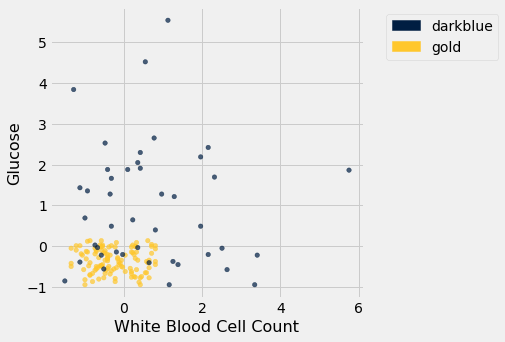

In [23]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Color')

Earlier, we said that we expect to get some classifications wrong, because there's some intermingling of blue and gold points in the lower-left.

But what about the points in the training set, that is, the points already on the scatter? Will we ever mis-classify them?

The answer is no. Remember that 1-nearest neighbor classification looks for the point *in the training set* that is nearest to the point being classified. Well, if the point being classified is already in the training set, then its nearest neighbor in the training set is itself! And therefore it will be classified as its own color, which will be correct because each point in the training set is already correctly colored.

In other words, **if we use our training set to "test" our 1-nearest neighbor classifier, the classifier will pass the test 100% of the time.**

Mission accomplished. What a great classifier! 

No, not so much. A new point in the lower-left might easily be mis-classified, as we noted earlier. "100% accuracy" was a nice dream while it lasted.

The lesson of this example is *not* to use the training set to test a classifier that is based on it.

### Generating a Test Set ###
In earlier chapters, we saw that random sampling could be used to estimate the proportion of individuals in a population that met some criterion.  Unfortunately, we have just seen that the training set is not like a random sample from the population of all patients, in one important respect: Our classifier guesses correctly for a higher proportion of individuals in the training set than it does for individuals in the population.

When we computed confidence intervals for numerical parameters, we wanted to have many new random samples from a population, but we only had access to a single sample.  We solved that problem by taking bootstrap resamples from our sample.

We will use an analogous idea to test our classifier. We will *create two samples out of the original training set*, use one of the samples as our training set, and *the other one for testing*. 

So we will have three groups of individuals:
- a training set on which we can do any amount of exploration to build our classifier;
- a separate testing set on which to try out our classifier and see what fraction of times it classifies correctly;
- the underlying population of individuals for whom we don't know the true classes; the hope is that our classifier will succeed about as well for these individuals as it did for our testing set.

How to generate the training and testing sets? You've guessed it – we'll select at random.

There are 158 individuals in `ckd`. Let's use a random half of them for training and the other half for testing. To do this, we'll shuffle all the rows, take the first 79 as the training set, and the remaining 79 for testing.

In [24]:
shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

Now let's construct our classifier based on the points in the training sample:

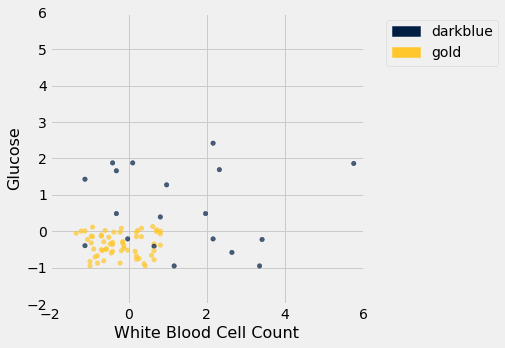

In [25]:
training.scatter('White Blood Cell Count', 'Glucose', colors='Color')
plt.xlim(-2, 6)
plt.ylim(-2, 6);

We get the following classification regions and decision boundary:

In [26]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Glucose', x_array,
    'White Blood Cell Count', y_array
)

In [27]:
c = classify_grid(training.drop('Hemoglobin', 'Color'), test_grid, 1)

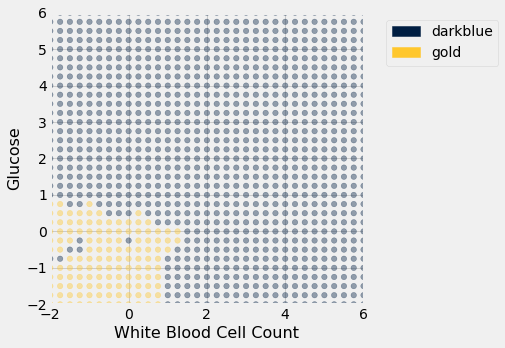

In [28]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Place the *test* data on this graph and you can see at once that while the classifier got almost all the points right, there are some mistakes.  For example, some blue points of the test set fall in the gold region of the classifier.

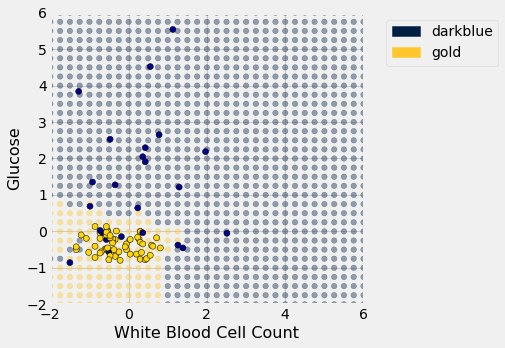

In [29]:
test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(testing.column('White Blood Cell Count'), testing.column('Glucose'), c=testing.column('Color'), edgecolor='k')

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Some errors notwithstanding, it looks like the classifier does fairly well on the test set. Assuming that the original sample was drawn randomly from the underlying population, the hope is that the classifier will perform with similar accuracy on the overall population, since the test set was chosen randomly from the original sample.

## Unit 18: Rows of Tables

In [30]:
import matplotlib
#matplotlib.use('Agg')
path_data = 'https://raw.githubusercontent.com/taecoding/data/master/cs61/data8assets/textbook/chapters/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

In [31]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

### Rows of Tables ###
Now that we have a qualitative understanding of nearest neighbor classification, it's time to implement our classifier.

Until this chapter, we have worked mostly with single columns of tables. But now we have to see whether one *individual* is "close" to another. Data for individuals are contained in *rows* of tables.

So let's start by taking a closer look at rows.

Here is the original table `ckd` containing data on patients who were tested for chronic kidney disease.

In [32]:
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')

The data corresponding to the first patient is in row 0 of the table, consistent with Python's indexing system. The Table method `row` accesses the row by taking the index of the row as its argument:

In [33]:
ckd.row(0)

Row(Age=48, Blood Pressure=70, Specific Gravity=1.005, Albumin=4, Sugar=0, Red Blood Cells='normal', Pus Cell='abnormal', Pus Cell clumps='present', Bacteria='notpresent', Glucose=117, Blood Urea=56, Serum Creatinine=3.8, Sodium=111, Potassium=2.5, Hemoglobin=11.2, Packed Cell Volume=32, White Blood Cell Count=6700, Red Blood Cell Count=3.9, Hypertension='yes', Diabetes Mellitus='no', Coronary Artery Disease='no', Appetite='poor', Pedal Edema='yes', Anemia='yes', Class=1)

Rows have their very own data type: they are *row objects*. Notice how the display shows not only the values in the row but also the labels of the corresponding columns.

Rows are in general **not arrays**, as their elements can be of different types. For example, some of the elements of the row above are strings (like `'abnormal'`) and some are numerical. So the row can't be converted into an array.

However, rows share some characteristics with arrays.  You can use `item` to access a particular element of a row. For example, to access the Albumin level of Patient 0, we can look at the labels in the printout of the row above to find that it's item 3:

In [34]:
ckd.row(0).item(3)

4

### Converting Rows to Arrays (When Possible) ###
Rows whose elements are all numerical (or all strings) can be converted to arrays.  Converting a row to an array gives us access to arithmetic operations and other nice NumPy functions, so it is often useful.

Recall that in the previous section we tried to classify the patients as 'CKD' or 'not CKD', based on two attributes `Hemoglobin` and `Glucose`, both measured in standard units. 

In [35]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)

color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd

Class,Hemoglobin,Glucose,Color
0,0.456884,0.133751,gold
0,1.153,-0.947597,gold
0,0.770138,-0.762223,gold
0,0.596108,-0.190654,gold
0,-0.239236,-0.49961,gold
0,-0.0304002,-0.159758,gold
0,0.282854,-0.00527964,gold
0,0.108824,-0.623193,gold
0,0.0740178,-0.515058,gold
0,0.83975,-0.422371,gold


Here is a scatter plot of the two attributes, along with a red point corresponding to Alice, a new patient. Her value of hemoglobin is 0 (that is, at the average) and glucose 1.1 (that is, 1.1 SDs above average).

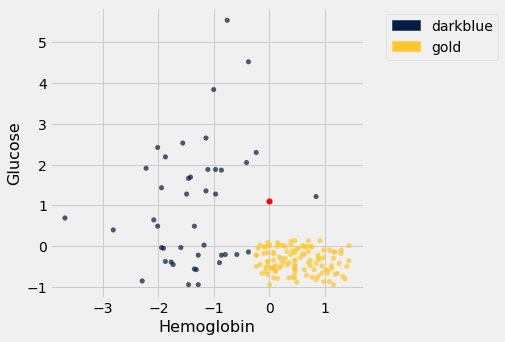

In [36]:
alice = make_array(0, 1.1)
ckd.scatter('Hemoglobin', 'Glucose', colors='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=30);

To find the distance between Alice's point and any of the other points, we only need the values of the attributes:

In [37]:
ckd_attributes = ckd.select('Hemoglobin', 'Glucose')

In [38]:
ckd_attributes

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961
-0.0304002,-0.159758
0.282854,-0.00527964
0.108824,-0.623193
0.0740178,-0.515058
0.83975,-0.422371


Each row consists of the coordinates of one point in our training sample. **Because the rows now consist only of numerical values**, it is possible to convert them to arrays.  For this, we use the function `np.array`, which converts any kind of sequential object, like a row, to an array. (Our old friend `make_array` is for *creating* arrays, not for *converting* other kinds of sequences to arrays.)

In [39]:
ckd_attributes.row(3)

Row(Hemoglobin=0.5961076648232668, Glucose=-0.19065363034327712)

In [40]:
np.array(ckd_attributes.row(3))

array([ 0.59610766, -0.19065363])

This is very handy because we can now use array operations on the data in each row.

### Distance Between Points When There are Two Attributes ###
The main calculation we need to do is to find the distance between Alice's point and any other point. For this, the first thing we need is a way to compute the distance between any pair of points. 

How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}
$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the hypotenuse.)



In the next section we'll see that this formula has a straightforward extension when there are more than two attributes. For now, let's use the formula and array operations to find the distance between Alice and the patient in Row 3.

In [41]:
patient3 = np.array(ckd_attributes.row(3))
alice, patient3

(array([0. , 1.1]), array([ 0.59610766, -0.19065363]))

In [42]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

1.421664918881847

We're going to need the distance between Alice and a bunch of points, so let's write a function called `distance` that computes the distance between any pair of points. The function will take two arrays, each containing the $(x, y)$ coordinates of a point.  (Remember, those are really the Hemoglobin and Glucose levels of a patient.)

In [43]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2.
    
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [44]:
distance(alice, patient3)

1.421664918881847

We have begun to build our classifier: the `distance` function is the first building block. Now let's work on the next piece.

### Using `apply` on an Entire Row ###
Recall that if you want to apply a function to each element of a column of a table, one way to do that is by the call `table_name.apply(function_name, column_label)`. This evaluates to an array consisting of the values of the function when we call it on each element of the column. So each entry of the array is based on the corresponding row of the table.

If you use `apply` without specifying a column label, then the entire row is passed to the function. Let's see how this works on a very small table `t` containing the information about the first five patients in the training sample.

In [45]:
t = ckd_attributes.take(np.arange(5))
t

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961


Just as an example, suppose that for each patient we want to know how unusual their most unusual attribute is.  Concretely, if a patient's hemoglobin level is further from the average than her glucose level, we want to know how far it is from the average.  If her glucose level is further from the average than her hemoglobin level, we want to know how far that is from the average instead.

That's the same as taking the maximum of the absolute values of the two quantities. To do this for a particular row, we can convert the row to an array and use array operations.

In [46]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

In [47]:
max_abs(t.row(4))

0.4996102825918697

And now we can apply `max_abs` to each row of the table `t`:

In [48]:
t.apply(max_abs)

array([0.4568837 , 1.15300352, 0.77013762, 0.59610766, 0.49961028])

This way of using `apply` will help us create the next building block of our classifier.

### Alice's $k$ Nearest Neighbors ###
If we want to classify Alice using a k-nearest neighbor classifier, we have to identify her $k$ nearest neighbors. What are the steps in this process? Suppose $k = 5$. Then the steps are:
- **Step 1.** Find the distance between Alice and each point in the training sample.
- **Step 2.** Sort the data table in increasing order of the distances.
- **Step 3.** Take the top 5 rows of the sorted table.

Steps 2 and 3 seem straightforward, provided we have the distances. So let's focus on Step 1.

Here's Alice:

In [49]:
alice

array([0. , 1.1])

What we need is a function that finds the distance between Alice and another point whose coordinates are contained in a row. The function `distance` returns the distance between any two points whose coordinates are in arrays. We can use that to define `distance_from_alice`, which takes a row as its argument and returns the distance between that row and Alice.

In [50]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [51]:
distance_from_alice(ckd_attributes.row(3))

1.421664918881847

Now we can `apply` the function `distance_from_alice` to each row of `ckd_attributes`, and augment the table `ckd` with the distances. Step 1 is complete!

In [52]:
distances = ckd_attributes.apply(distance_from_alice)
ckd_with_distances = ckd.with_column('Distance from Alice', distances)

In [53]:
ckd_with_distances

Class,Hemoglobin,Glucose,Color,Distance from Alice
0,0.456884,0.133751,gold,1.06882
0,1.153,-0.947597,gold,2.34991
0,0.770138,-0.762223,gold,2.01519
0,0.596108,-0.190654,gold,1.42166
0,-0.239236,-0.49961,gold,1.6174
0,-0.0304002,-0.159758,gold,1.26012
0,0.282854,-0.00527964,gold,1.1409
0,0.108824,-0.623193,gold,1.72663
0,0.0740178,-0.515058,gold,1.61675
0,0.83975,-0.422371,gold,1.73862


For Step 2, let's sort the table in increasing order of distance:

In [54]:
sorted_by_distance = ckd_with_distances.sort('Distance from Alice')
sorted_by_distance

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534
0,0.387272,0.118303,gold,1.05532
0,0.456884,0.133751,gold,1.06882
0,0.178436,0.0410639,gold,1.07386
0,0.00440582,0.025616,gold,1.07439
0,-0.169624,0.025616,gold,1.08769


Step 3: The top 5 rows correspond to Alice's 5 nearest neighbors; you can replace 5 by any other positive integer.

In [55]:
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534


Three of Alice's five nearest neighbors are blue points and two are gold. So a 5-nearest neighbor classifier would classify Alice as blue: it would predict that Alice has chronic kidney disease.

The graph below zooms in on Alice and her five nearest neighbors. The two gold ones just inside the circle directly below the red point. The classifier says Alice is more like the three blue ones around her.

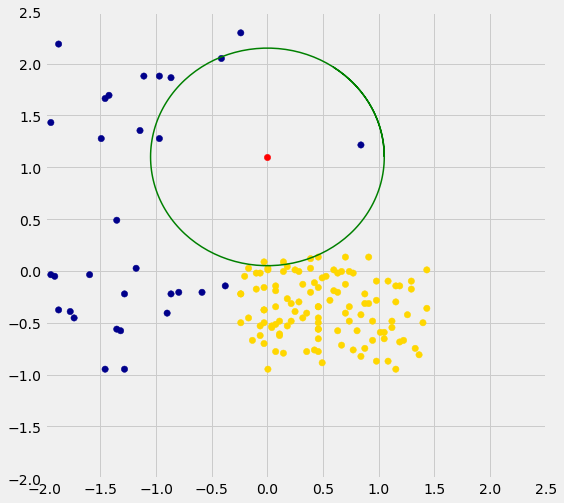

In [56]:
plots.figure(figsize=(8,8))
plots.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), s=40)
#ckd.scatter('Hemoglobin', 'Glucose', group='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=40)
radius = sorted_by_distance.column('Distance from Alice').item(4)+0.014
theta = np.arange(0, 2*np.pi+1, 2*np.pi/200)
plots.plot(radius*np.cos(theta)+alice.item(0), radius*np.sin(theta)+alice.item(1), color='g', lw=1.5);
plots.xlim(-2, 2.5)
plots.ylim(-2, 2.5);

We are well on our way to implementing our k-nearest neighbor classifier. In the next two sections we will put it together and assess its accuracy.